In [11]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json
import nltk
import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [12]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [13]:
# Load data
data_train = pd.read_csv('../Data Splits/train_data_70_30.csv')
data_val = pd.read_csv('../Data Splits/val_data_70_30.csv')

In [14]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [15]:
# Text preprocessing
def remove_diacritics(text):
    normalized = unicodedata.normalize("NFD", text)
    return "".join(c for c in normalized if unicodedata.category(c) != "Mn")

def wordopt(text):
    text = text.lower()
    text = remove_diacritics(text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"\\W", " ", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

ps = PorterStemmer()
with open('../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

def preprocess(text):
    text = wordopt(text)
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(token) for token in tokens]
    filtered = [stem for stem in stems if stem not in stopwords]
    return filtered

In [16]:
# Apply preprocess function to X_train
X_train = X_train.apply(preprocess)

# Apply preprocess function to X_val
X_val = X_val.apply(preprocess)

In [17]:
# Convert the preprocessed text into a list of strings
X_train_processed = [' '.join(tokens) for tokens in X_train]
X_val_processed = [' '.join(tokens) for tokens in X_val]

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_processed)

# Transform the validation data using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(X_val_processed)

# Print the shape of the TF-IDF matrices (No of rows, No of columns)
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_val_tfidf:", X_val_tfidf.shape)

Shape of X_train_tfidf: (2019, 28540)
Shape of X_val_tfidf: (866, 28540)


In [18]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [19]:
# Define the XGBClassifier as meta learner
mlp = MLPClassifier()

# Define the parameter grid
param_grid = {
            'hidden_layer_sizes': [(10,), (20,), (50,), (100,)], 
            'activation': ['relu', 'tanh', 'logistic'], 
            'solver': ['sgd', 'adam'], 
            'learning_rate': ['constant', 'adaptive']
            }

# Define the GridSearchCV
mlp_grid = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

In [20]:
mlp_grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh', 'logistic'],
                         'hidden_layer_sizes': [(10,), (20,), (50,), (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [21]:
print("Best Hyperparameters: ", mlp_grid.best_params_)
print("Best Accuracy: {:.2f}%".format(mlp_grid.best_score_ * 100))

Best Hyperparameters:  {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
Best Accuracy: 95.05%


In [31]:
best_meta = mlp_grid.best_estimator_
joblib.dump(best_meta, '../Models/70-30 Test/stackmodel_mlp_best_estimator.joblib')

['../Models/70-30 Test/stackmodel_mlp_best_estimator.joblib']

In [32]:
stack = StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta, cv=5)
stack.fit(X_train_tfidf, y_train)

StackingClassifier(cv=5,
                   estimators=[('MNB', MultinomialNB()),
                               ('LR', LogisticRegression()),
                               ('RF', RandomForestClassifier()),
                               ('KNN', KNeighborsClassifier()),
                               ('SVM', SVC(probability=True))],
                   final_estimator=MLPClassifier(activation='tanh'))

Metrics for MNB:
Accuracy: 0.8579676674364896
Precision: 0.7958015267175572
Recall: 0.9630484988452656
F1 Score: 0.8714733542319749
AUC: 0.9715556645989899
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       433
           1       0.80      0.96      0.87       433

    accuracy                           0.86       866
   macro avg       0.87      0.86      0.86       866
weighted avg       0.87      0.86      0.86       866



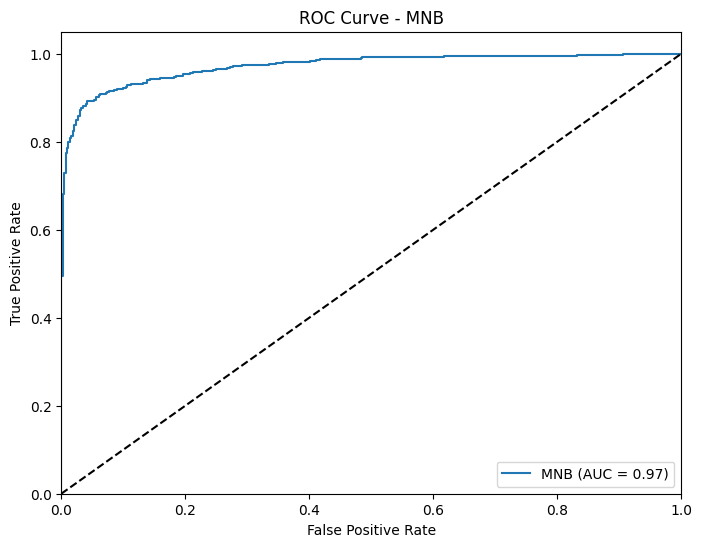

Metrics for LR:
Accuracy: 0.9341801385681293
Precision: 0.9723618090452262
Recall: 0.8937644341801386
F1 Score: 0.9314079422382672
AUC: 0.9843724165151022
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       433
           1       0.97      0.89      0.93       433

    accuracy                           0.93       866
   macro avg       0.94      0.93      0.93       866
weighted avg       0.94      0.93      0.93       866



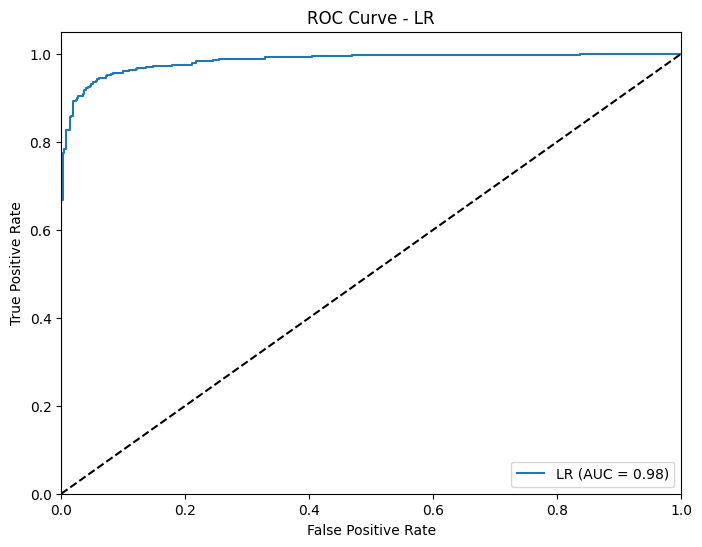

Metrics for RF:
Accuracy: 0.9353348729792148
Precision: 0.9631449631449631
Recall: 0.9053117782909931
F1 Score: 0.9333333333333333
AUC: 0.9846257647115298
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       433
           1       0.96      0.91      0.93       433

    accuracy                           0.94       866
   macro avg       0.94      0.94      0.94       866
weighted avg       0.94      0.94      0.94       866



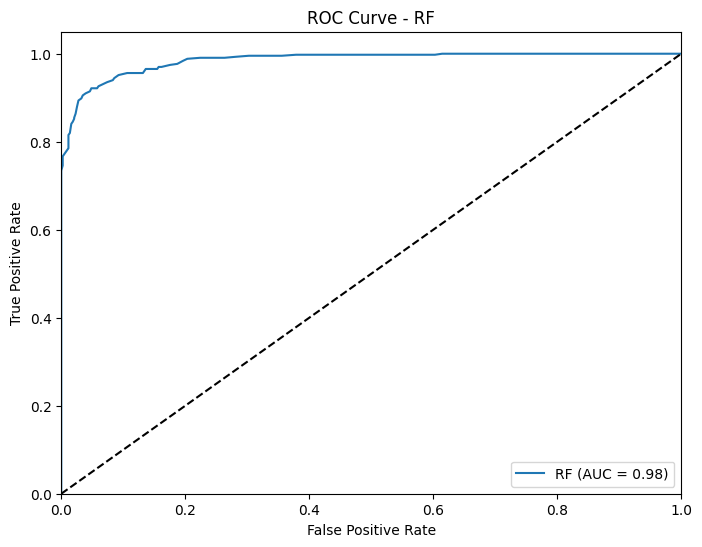

Metrics for KNN:
Accuracy: 0.8475750577367206
Precision: 0.7992047713717694
Recall: 0.9284064665127021
F1 Score: 0.8589743589743589
AUC: 0.9394257796457393
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       433
           1       0.80      0.93      0.86       433

    accuracy                           0.85       866
   macro avg       0.86      0.85      0.85       866
weighted avg       0.86      0.85      0.85       866



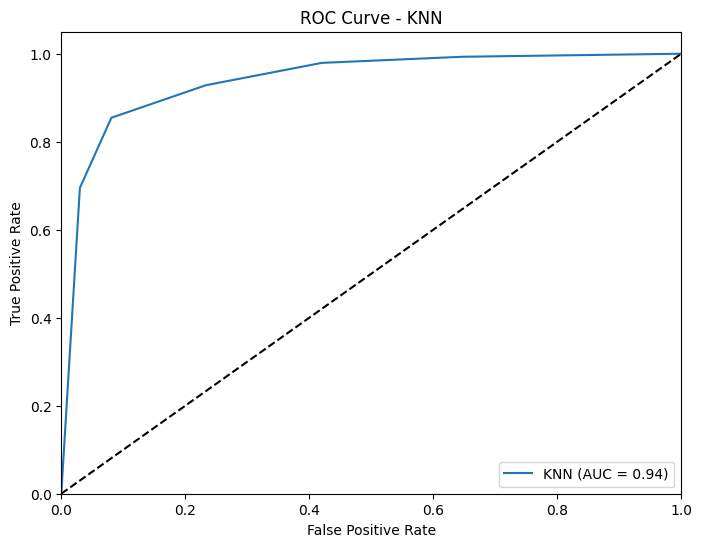

Metrics for SVM:
Accuracy: 0.9445727482678984
Precision: 0.9800498753117207
Recall: 0.9076212471131639
F1 Score: 0.9424460431654677
AUC: 0.9888366784184673
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       433
           1       0.98      0.91      0.94       433

    accuracy                           0.94       866
   macro avg       0.95      0.94      0.94       866
weighted avg       0.95      0.94      0.94       866



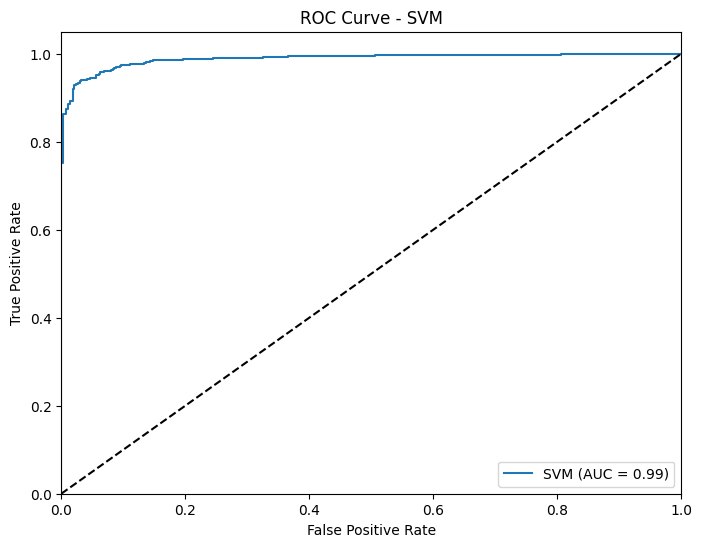

In [33]:
# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])


# Evaluate base models
for model, name in zip(base_models, base_names):
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    y_prob = model.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9561200923787528
Precision: 0.9603729603729604
Recall: 0.9515011547344111
F1 Score: 0.9559164733178654
AUC: 0.9905221106304902
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       433
           1       0.96      0.95      0.96       433

    accuracy                           0.96       866
   macro avg       0.96      0.96      0.96       866
weighted avg       0.96      0.96      0.96       866



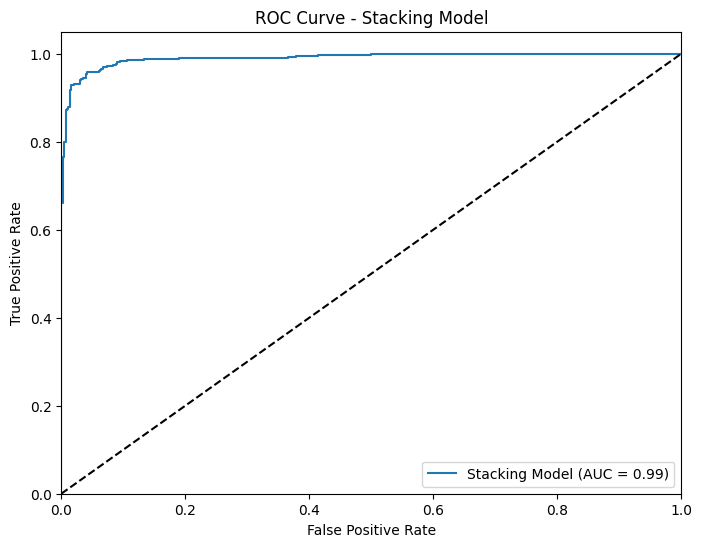

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.857968  0.795802  0.963048  0.871473  0.971556
LR               0.93418  0.972362  0.893764  0.931408  0.984372
RF              0.935335  0.963145  0.905312  0.933333  0.984626
KNN             0.847575  0.799205  0.928406  0.858974  0.939426
SVM             0.944573   0.98005  0.907621  0.942446  0.988837
Stacking Model   0.95612  0.960373  0.951501  0.955916  0.990522


In [34]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val_tfidf)
stack_y_prob = stack.predict_proba(X_val_tfidf)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [36]:
# Save the model using joblib
joblib.dump(stack, '../Models/70-30 Test/stackmodel_mlp.joblib')

['../Models/70-30 Test/stackmodel_mlp.joblib']